# Dissecting Spotify's Valence
Spotify uses a metric called **"valence"** to measure the happines of each track. This metric, however was developed from a company called "EchoNest", and not Spotify, and we do not know how exactly this metric is measured. In this notebook, i will attempt to:<br />
1) understand which songs' audio features affect valence and which do not, and<br />
2) predict the valence for a new dataset of songs with various machine learning models

The data i will use come from 2 differnet sources:<br />
1) **"tracks.csv"** (from: https://www.kaggle.com/lehaknarnauli/spotify-datasets) which contains aproximately 586,000 songs and their audio features<br />
2) **"spotify_ids.txt"** (which contains approximately 1160 song id's). By connecting to Spotify's API, i will iteratively get all these songs ids' audio features, and use this dataset for out-of sample predictions.<br />

For predictions, i will use the following methods: **Decision Tree**, **XGBoost**, **Beta Regression** and **K-Nearest Neighbors**.<br />
<br />
First, i will load the libraries that will be used

In [45]:
# Importing the libraries i need
import numpy as np 
import pandas as pd
import seaborn as sns
import time
import matplotlib.pyplot as plt
import statsmodels.api as sm
import scipy.stats.stats as stats
from statsmodels.stats.outliers_influence import variance_inflation_factor
from statsmodels.tools.tools import add_constant
import statsmodels.formula.api as smf
from termcolor import cprint
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import mean_absolute_error
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import MinMaxScaler
from sklearn.feature_selection import RFE
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import f_regression
from sklearn import neighbors
from math import sqrt
from xgboost import XGBRegressor
import spotipy
from spotipy.oauth2 import SpotifyClientCredentials

%matplotlib inline

### Importing the dataset

In [46]:
# Importing the dataset "tracks.csv" i got from Kaggle
data = pd.read_csv("tracks.csv")

### Checking the data

In [47]:
cprint("First 5 rows of 'data' dataset:", "green")
data.head()

First 5 rows of 'data' dataset:


,id,name,popularity,duration_ms,explicit,artists,id_artists,release_date,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,time_signature
0,35iwgR4jXetI318WEWsa1Q,Carve,6,126903,0,['Uli'],['45tIt06XoI0Iio4LBEVpls'],1922-02-22,0.645,0.4450,0,-13.338,1,0.4510,0.674,0.7440,0.151,0.127,104.851,3
1,021ht4sdgPcrDgSk7JTbKY,Capítulo 2.16 - Banquero Anarquista,0,98200,0,['Fernando Pessoa'],['14jtPCOoNZwquk5wd9DxrY'],1922-06-01,0.695,0.2630,0,-22.136,1,0.9570,0.797,0.0000,0.148,0.655,102.009,1
2,07A5yehtSnoedViJAZkNnc,Vivo para Quererte - Remasterizado,0,181640,0,['Ignacio Corsini'],['5LiOoJbxVSAMkBS2fUm3X2'],1922-03-21,0.434,0.1770,1,-21.180,1,0.0512,0.994,0.0218,0.212,0.457,130.418,5
3,08FmqUhxtyLTn6pAh6bk45,El Prisionero - Remasterizado,0,176907,0,['Ignacio Corsini'],['5LiOoJbxVSAMkBS2fUm3X2'],1922-03-21,0.321,0.0946,7,-27.961,1,0.0504,0.995,0.9180,0.104,0.397,169.980,3
4,08y9GfoqCWfOGsKdwojr5e,Lady of the Evening,0,163080,0,['Dick Haymes'],['3BiJGZsyX9sJchTqcSA7Su'],1922,0.402,0.1580,3,-16.900,0,0.0390,0.989,0.1300,0.311,0.196,103.220,4


In [48]:
cprint("Basic Information for the 'data' dataset:", "green")
data.info()
cprint("Shape of 'data' dataset:", "green")
data.shape

Basic Information for the 'data' dataset:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 586672 entries, 0 to 586671
Data columns (total 20 columns):
 #   Column            Non-Null Count   Dtype  
---  ------            --------------   -----  
 0   id                586672 non-null  object 
 1   name              586601 non-null  object 
 2   popularity        586672 non-null  int64  
 3   duration_ms       586672 non-null  int64  
 4   explicit          586672 non-null  int64  
 5   artists           586672 non-null  object 
 6   id_artists        586672 non-null  object 
 7   release_date      586672 non-null  object 
 8   danceability      586672 non-null  float64
 9   energy            586672 non-null  float64
 10  key               586672 non-null  int64  
 11  loudness          586672 non-null  float64
 12  mode              586672 non-null  int64  
 13  speechiness       586672 non-null  float64
 14  acousticness      586672 non-null  float64
 15  instrumentalness  586672 n

(586672, 20)

As it can be seen, the dataset has **586672** rows and **20** columns.<br />
Next, we can see some summary statistics about the dataset "data"

In [49]:
cprint("Summary statistics for 'data' dataset:", "green")
data.describe()

Summary statistics for 'data' dataset:


,popularity,duration_ms,explicit,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,time_signature
count,586672.000000,5.866720e+05,586672.000000,586672.000000,586672.000000,586672.000000,586672.000000,586672.000000,586672.000000,586672.000000,586672.000000,586672.000000,586672.000000,586672.000000,586672.000000
mean,27.570053,2.300512e+05,0.044086,0.563594,0.542036,5.221603,-10.206067,0.658797,0.104864,0.449863,0.113451,0.213935,0.552292,118.464857,3.873382
std,18.370642,1.265261e+05,0.205286,0.166103,0.251923,3.519423,5.089328,0.474114,0.179893,0.348837,0.266868,0.184326,0.257671,29.764108,0.473162
min,0.000000,3.344000e+03,0.000000,0.000000,0.000000,0.000000,-60.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,13.000000,1.750930e+05,0.000000,0.453000,0.343000,2.000000,-12.891000,0.000000,0.034000,0.096900,0.000000,0.098300,0.346000,95.600000,4.000000
50%,27.000000,2.148930e+05,0.000000,0.577000,0.549000,5.000000,-9.243000,1.000000,0.044300,0.422000,0.000024,0.139000,0.564000,117.384000,4.000000
75%,41.000000,2.638670e+05,0.000000,0.686000,0.748000,8.000000,-6.482000,1.000000,0.076300,0.785000,0.009550,0.278000,0.769000,136.321000,4.000000
max,100.000000,5.621218e+06,1.000000,0.991000,1.000000,11.000000,5.376000,1.000000,0.971000,0.996000,1.000000,1.000000,1.000000,246.381000,5.000000


We can observe here that variables "explicit", "mode", "speechiness", "instrumentalness", "liveness" and "time_signature" are quite unbalanced and assymetric, as their means and medians have a decent difference. These variables may decrease the quality of some model we will see later, as some models are greatly affected by imbalanced variables.
<br />
After that, i check for Null values in "data":

In [50]:
pd.isnull(data).sum()

id                   0
name                71
popularity           0
duration_ms          0
explicit             0
artists              0
id_artists           0
release_date         0
danceability         0
energy               0
key                  0
loudness             0
mode                 0
speechiness          0
acousticness         0
instrumentalness     0
liveness             0
valence              0
tempo                0
time_signature       0
dtype: int64

We can se that the only variable with null values is the "name" variable. Since we won't use this variable, we ignore the existence of these missing values.<br />
<br />
### Exploring which Track Features Influence Valence
Now, having taken a look in the "data" dataset, we can start exploring the variables. At first, i will make a **Correlation Heatmap between the variables** with **Pearson's Correlation Coefficient** . This coefficient will show us possible **linear** correlations between the variables.<br />
Empirical rule for linear correlation scores of 2 variables:<br />
**0.0** - **0.4** Non-existent or weak positive linear correlation<br />
**0.4** - **0.7** Medium linear positive correlation<br />
**0.7** - **1.0** Strong linear positive correlation<br />
and<br />
 **0.0** - **-0.4** Non-existent or weak negative linear correlation<br />
**-0.4** - **-0.7** Medium negative linear correlation<br />
**-0.7** - **-1.0** Strong negative linear correlation

[Text(0.5, 0, 'popularity'),
 Text(1.5, 0, 'duration_ms'),
 Text(2.5, 0, 'danceability'),
 Text(3.5, 0, 'energy'),
 Text(4.5, 0, 'key'),
 Text(5.5, 0, 'loudness'),
 Text(6.5, 0, 'speechiness'),
 Text(7.5, 0, 'acousticness'),
 Text(8.5, 0, 'instrumentalness'),
 Text(9.5, 0, 'liveness'),
 Text(10.5, 0, 'valence'),
 Text(11.5, 0, 'tempo'),
 Text(12.5, 0, 'time_signature')]

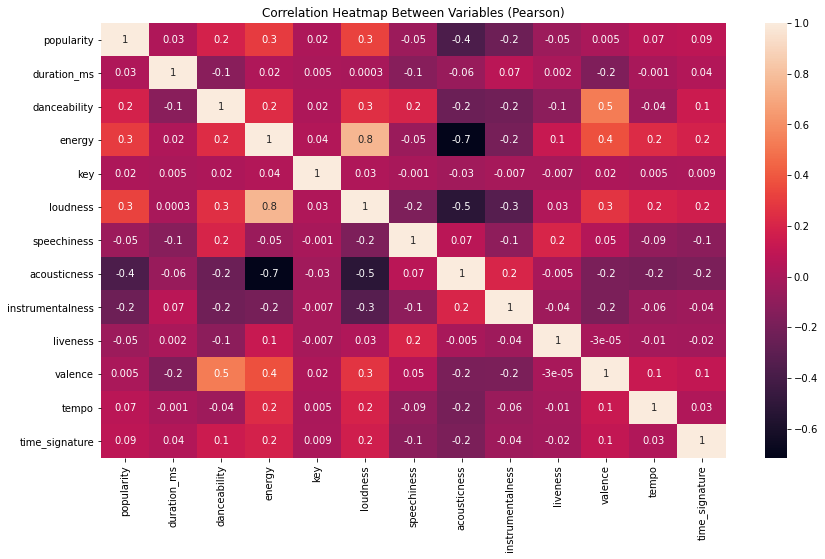

In [51]:
# Here we calculate the Pearson Coefficient that captures linear relationships
corr_df=data.drop(['mode','explicit'], axis=1).corr(method='pearson')
plt.figure(figsize=(14,8))
heatmap=sns.heatmap(corr_df, annot=True, fmt='.1g')
heatmap.set_title('Correlation Heatmap Between Variables (Pearson)')
heatmap.set_xticklabels(heatmap.get_xticklabels(), rotation=90)

As we can easily observe, "valence" seems to have a medium positive linear relationship with "danceability" and "energy", a weak linear positive relationship with "loudness" and a weak linear negative relationship with "acousticness" and "instrumentalness".<br />
Another interesting relationship between variables, is the one between "acousticness" and "energy". These 2 have a strong negative linear relationship, indicating that they could be suspicious for multicollinearity.<br /> 
On more visible relationship is the one between "acousticness" and "loudness",which is medium negatively linear. It appears that "acousticness" must have a high probability of causing multicollinearity later in modelling.<br />

Now,i will make a **Correlation Heatmap between the variables** with **Spearman's Correlation Coefficient** . This coefficient will show us possible **linear** and **non-linear** correlations between the variables.<br />

[Text(0.5, 0, 'popularity'),
 Text(1.5, 0, 'duration_ms'),
 Text(2.5, 0, 'danceability'),
 Text(3.5, 0, 'energy'),
 Text(4.5, 0, 'key'),
 Text(5.5, 0, 'loudness'),
 Text(6.5, 0, 'speechiness'),
 Text(7.5, 0, 'acousticness'),
 Text(8.5, 0, 'instrumentalness'),
 Text(9.5, 0, 'liveness'),
 Text(10.5, 0, 'valence'),
 Text(11.5, 0, 'tempo'),
 Text(12.5, 0, 'time_signature')]

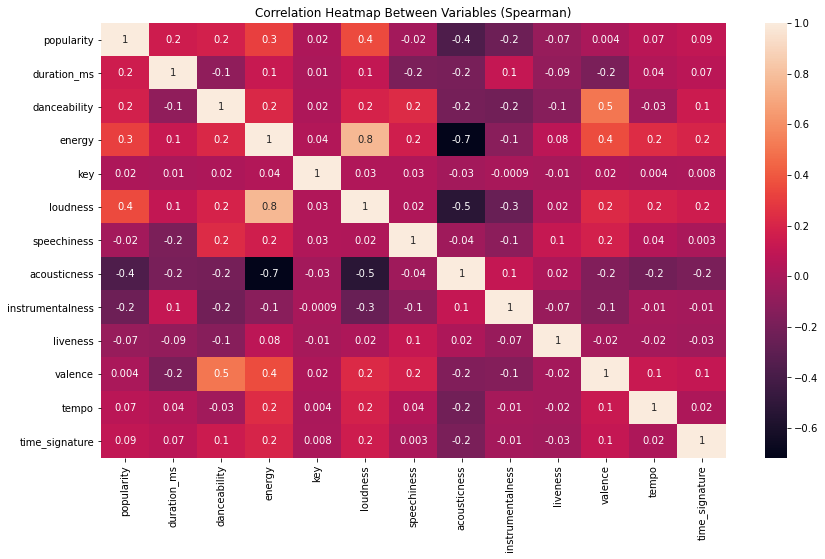

In [52]:
# Here we calculate the Spearman Coefficient that captures non-linear relationships too
corr_df=data.drop(['mode','explicit'], axis=1).corr(method='spearman')
plt.figure(figsize=(14,8))
heatmap=sns.heatmap(corr_df, annot=True, fmt='.1g')
heatmap.set_title('Correlation Heatmap Between Variables (Spearman)')
heatmap.set_xticklabels(heatmap.get_xticklabels(), rotation=90)

This correlation heatmap is similar to the one above, with the only difference that the previous one would use the Pearson Coefficient that can detect linear relationships, while this one uses the Spearmann coefficient that can capture non-linear relationships too. Also, it shares the same empirical rule with the previous heatmap<br /> 
By comparing them, we can see that there are no significant differences between them, so the second heatmap is not that useful, as there were no new important non-linear relationships discovered.

### Generalized Linear Model
As the response variable ("valence") can take values belonging to the range (0, 1), a simple Linear Regression Model is not suitable to model "valence", so i will use a **Generalized Linear Model**.<br /> 
More precisely, i will use **Beta Regression**, a regression suitable for modelling response variables that are percentages (meaning that they belong to the (0, 1) range).<br />
To do this, i have to choose **family = "Binomial"** and as a link function the **"logit"** function.

In [53]:
y = data.valence
x = data[["duration_ms", "danceability", "energy", "loudness", "speechiness", "acousticness", \
            "instrumentalness", "liveness", "tempo", "time_signature"]]
data_reg = pd.concat([y, x], axis=1)

# By choosing to family = "Binomial" and logit function, we replicate a "Beta Regression", which is a regression
# for response variables that are continuous and belong to the (0, 1) space. 

fit = smf.glm(formula='valence ~ duration_ms + danceability + energy + loudness + speechiness + acousticness \
            + instrumentalness + liveness + tempo + time_signature', 
              data=data_reg, 
              family=sm.families.Binomial(link=sm.families.links.logit())).fit() 

### Checking for Multicolinearity
Now, i will check for multicolinearity between the independent variables (features). To do so, i construct a function named **"compute_vif"** that takes as inputs all the independent variables used in the model. Variables with scores >= 10, will be removed, and the model will be re-fitted with the the variables left.

In [54]:
def compute_vif(considered_features):
    
    '''This function takes as input all the independent variables used in GLM's fitting,
    and calculates the variance inflation factor of each one of them.'''
    
    X = data[considered_features]
    # calculation of variance inflation requires a constant
    X['intercept'] = 1
    
    # creating a dataframe to store vif values
    vif = pd.DataFrame()
    vif["Variable"] = X.columns
    vif["VIF"] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]
    vif = vif[vif['Variable']!='intercept']
    return vif

In [55]:
compute_vif(["duration_ms", "danceability", "energy", "loudness", "speechiness", "acousticness", \
            "instrumentalness", "liveness", "tempo", "time_signature"])

<ipython-input-54-e7ff937e7752>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X['intercept'] = 1


,Variable,VIF
0,duration_ms,1.039020
1,danceability,1.264082
2,energy,3.969678
3,loudness,2.867520
4,speechiness,1.239150
5,acousticness,2.169482
6,instrumentalness,1.210585
7,liveness,1.125676
8,tempo,1.077651
9,time_signature,1.070427


Since no variable has a score greater than 10, we can assume that the independent variables do not exhibit multicollinearity and that these variables are indeed independent. That means that i will stick to the model that i made previously.

### Goodness of fit tests 
Next step is to conduct goodness of fit tests to check the model's quality and then interpret it.

In [56]:
fit.summary2() # "Deviance" to "Df Residuals" ratio: 0.1863

<class 'statsmodels.iolib.summary2.Summary'>
"""
                Results: Generalized linear model
==================================================================
Model:              GLM              AIC:            532806.8065  
Link Function:      logit            BIC:            -7682878.1999
Dependent Variable: valence          Log-Likelihood: -2.6639e+05  
Date:               2022-03-06 14:43 LL-Null:        -3.0029e+05  
No. Observations:   586672           Deviance:       1.0928e+05   
Df Model:           10               Pearson chi2:   1.06e+05     
Df Residuals:       586661           Scale:          1.0000       
Method:             IRLS                                          
------------------------------------------------------------------
                  Coef.  Std.Err.     z     P>|z|   [0.025  0.975]
------------------------------------------------------------------
Intercept        -4.0305   0.0371 -108.5942 0.0000 -4.1032 -3.9577
duration_ms      -0.0000   0.0000  -42.5869 0.0000 -0.0000 -0.0000
danceability      3.4981   0.0197  177.2386 0.0000  3.4594  3.5368
energy            2.4912   0.0226  110.4185 0.0000  2.4470  2.5355
loudness         -0.0417   0.0009  -44.5108 0.0000 -0.0436 -0.0399
speechiness      -0.5966   0.0170  -35.1067 0.0000 -0.6299 -0.5632
acousticness      0.8964   0.0120   74.7753 0.0000  0.8729  0.9199
instrumentalness -0.3066   0.0116  -26.5184 0.0000 -0.3293 -0.2840
liveness          0.0593   0.0160    3.7037 0.0002  0.0279  0.0906
tempo             0.0042   0.0001   43.7931 0.0000  0.0041  0.0044
time_signature   -0.0087   0.0061   -1.4232 0.1547 -0.0208  0.0033
==================================================================

"""

In [57]:
# 1st Goodness of Fit test: Deviance to Df residuals ratio
round(109280/586661, 3)

0.186

The first Goodness of Fit measure is the ratio of Deviance to Degrees of Freedom Residuals. The closer this ratio is to 1, the better the model is. From the summary() function above, we take these 2 values and we can see that this ratio is equal to 0.186. That is quite far from 1, meaning that the model is not ideal.

In [58]:
# 2nd Goodness of Fit test: Pseudo R-squared
round(1 - fit.llf/fit.llnull, 3)

0.113

The second Goodness of Fit test is the pseudo R-squared. Since this model is not linear, we can not use the R-squared or the adjusted R-squared (in case we had multiple independent variables), so we will use one of the many pseudo R-squared. The models Pseudo R-squared value is equal to 11.3 %, meaning that the model explains 11.3% of the valence's variability. That is quite low, and it means that the model does not fit the data well.

### Feature Selection
To select better variables, i will use the SelectKBest method from sklearn with the "f_regression" method as a scoring function. The output of this method will be a dataframe including every feature and its score from "f-regression" scoring function. The higher the score, the more important is the influence of the feature in Valence.

In [87]:
names = pd.DataFrame(x.columns)

model = SelectKBest(score_func=f_regression, k=10)
results = model.fit(x, y)
results_df=pd.DataFrame(results.scores_)

scored=pd.concat([names,results_df], axis=1)
scored.columns = ["Feature", "Score"]
scored.sort_values(by=['Score']) 

,Feature,Score
7,liveness,0.000688
4,speechiness,1271.337803
9,time_signature,6606.905868
8,tempo,10931.622474
0,duration_ms,16053.406757
6,instrumentalness,18583.887090
5,acousticness,19856.947251
3,loudness,48166.194790
2,energy,94387.523218
1,danceability,226954.127129


I will randomly choose the first 5 features with the highest scores and i will fit another model.

### Fitting a new model
Now, we choose the first 5 variables (meaning the 5 highest scoring variables) and fit the model with them.

In [60]:
fit2 = smf.glm(formula='valence ~ danceability + energy + loudness + acousticness \
            + instrumentalness', 
              data=data_reg, 
              family=sm.families.Binomial(link=sm.families.links.logit())).fit()

In [61]:
fit2.summary2()

<class 'statsmodels.iolib.summary2.Summary'>
"""
                Results: Generalized linear model
==================================================================
Model:              GLM              AIC:            538046.1708  
Link Function:      logit            BIC:            -7677695.2468
Dependent Variable: valence          Log-Likelihood: -2.6902e+05  
Date:               2022-03-06 14:43 LL-Null:        -3.0029e+05  
No. Observations:   586672           Deviance:       1.1453e+05   
Df Model:           5                Pearson chi2:   1.09e+05     
Df Residuals:       586666           Scale:          1.0000       
Method:             IRLS                                          
------------------------------------------------------------------
                  Coef.  Std.Err.     z     P>|z|   [0.025  0.975]
------------------------------------------------------------------
Intercept        -3.6700   0.0249 -147.5222 0.0000 -3.7188 -3.6213
danceability      3.3184   0.0183  180.8885 0.0000  3.2825  3.3544
energy            2.4616   0.0217  113.6522 0.0000  2.4191  2.5040
loudness         -0.0320   0.0009  -35.7988 0.0000 -0.0338 -0.0303
acousticness      0.8771   0.0117   74.8112 0.0000  0.8541  0.9000
instrumentalness -0.2732   0.0113  -24.1722 0.0000 -0.2954 -0.2511
==================================================================

"""

### Goodnes of Fit test for the new model

In [62]:
# 1st Goodness of Fit test: Deviance to Df residuals ratio
round(114500/586672, 3)

0.195

The Deviance to Df Residuals ratio is slightly higher in this model than in the previous one (that had all the variables)

In [63]:
# 2nd Goodness of Fit test: Pseudo R-squared
round(1 - fit2.llf/fit2.llnull, 3)

0.104

As we can see, the second model has only 5 independent variables instead of 10 (like the first one).Also,it has sligthly higher Deviance to Df Residuals ratio but slightly lower pseudo R-squared. Since the new model is quite similar in terms of Goodness of Fit tests, i will choose it as the final one since it has only 5 independent variables, making it easier to understand and interpret.

Beta regression's formula looks like this:<br />
logit($\hat{y}_{i}) = \hat{\beta}_{0} + \sum \limits _{i=1} ^{p}\hat{\beta}_{i} $<br />
and in our case, our model is the following:<br />
logit($\hat{valence}_{i}) = -3.67 + 3.31*\hat{danceability} + 2.46*\hat{energy} - 0.032*\hat{loudness} + 0.87*\hat{acousticness} - 0.27*\hat{instrumentalness}. $<br />

Every extra increase of one unit in the **danceability** increases the log odds by 3.31 and 
multiplies the actual odds by e^3.31 = 27,38, when all other dependent variables are 
stable. <br />

Every extra increase of one unit in the **energy** increases the log odds by 2.46 and 
multiplies the actual odds by e^2.46 = 11,70, when all other dependent variables are 
stable. <br />

Every extra increase of one unit in the **loudness** decreases the log odds by 0.032 and 
multiplies the actual odds by e^0.032 = 1.03, when all other dependent variables are 
stable. <br />

Every extra increase of one unit in the **acousticness** increases the log odds by 0.87 and 
multiplies the actual odds by e^0.87 = 2,38, when all other dependent variables are 
stable. <br />

Every extra increase of one unit in the **instrumentalness** decreases the log odds by 0.27 and 
multiplies the actual odds by e^0.27 = 1,30, when all other dependent variables are 
stable. <br />

Overall, as we can see from both the above equation and the feature selection section above, that the variables tha affect valence the most, are **"danceability"**, **"energy"**, **"loudness"**, **"acousticness"**, **"instrumentalness"**, with **"danceability"** and **"energy"** having the most significant influence in the "valence" metric.

### Predicting Valence (Question 2.)
Now, i will train some models with data from the Kaggle dataset, and i will use the second dataset in order to find out-of sample Mean Average Errors. In the end, for every model, i will compare **in-sample MAE's** and **out-of sample MAE's**, so i can pick a final model.<br />
First, i must select the prediction target Y (valence) and the features. Even though i implemented feature selection already and ended up to 5 variables, i will now use all of them, as many models do feature selection by their own (e.g. Decision Trees and Random Forests).<br />
Also, i split the data to **train data** (75% of the initial dataset) and **validation data** (25% of the initial dataset)

In [64]:
######################################
############ Question 2 ##############
######################################

# selecting the prediction target
y = data.valence

# Choosing the features
feats = ["duration_ms", "danceability", "energy", "loudness", "speechiness", "acousticness",
            "instrumentalness", "liveness", "tempo", "time_signature"] 
#feats = ["danceability", "energy", "loudness", "acousticness",
#            "instrumentalness"]
X = data[feats]

# Spliting data to training data and validation data
train_X, val_X, train_y, val_y = train_test_split(X, y, random_state = 1, test_size = 0.25)

### K-Nearest Neighbors
The first ML algorithm will be K-Nearest Neighbors. After testing manually this method's MAE result with and without Scaling, i ended up with Scaling the data for this algorithm as it gave me a better MAE (both in-sample and out-of sample). The scaling range is (0, 1).

In [65]:
scaler = MinMaxScaler(feature_range=(0, 1))

x_train_scaled = scaler.fit_transform(train_X)
x_train_sc = pd.DataFrame(x_train_scaled)

x_test_scaled = scaler.fit_transform(val_X)
x_test_sc = pd.DataFrame(x_test_scaled)

After scaling the data for this model, i will fit it with different K's to see for which K value we get the lowest in-sample MAE.

In [66]:
mae_val = [] 
start_time = time.time()
for K in range(24, 30):
    K = K+1
    model = neighbors.KNeighborsRegressor(n_neighbors = K)

    model.fit(x_train_sc, train_y)  #fit the model
    pred=model.predict(x_test_sc) # make prediction on test set
    error = round(mean_absolute_error(val_y,pred), 6) 
    mae_val.append(error) 
    print('MAE value for K=' , K , 'is:', error)
duration_knn = round((time.time() - start_time)/60, 2) 

MAE value for K= 25 is: 0.148503
MAE value for K= 26 is: 0.148485
MAE value for K= 27 is: 0.148507
MAE value for K= 28 is: 0.148531
MAE value for K= 29 is: 0.148509
MAE value for K= 30 is: 0.148521


Now, i will plot all these K values against their corresponding MAE.

Text(0, 0.5, 'Mean Average Error')

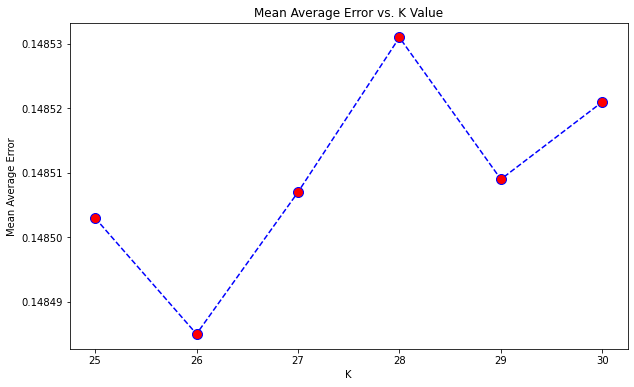

In [67]:
curve = pd.DataFrame(mae_val) #elbow curve 
curve["K_value"] = [25, 26, 27, 28, 29, 30]
curve.columns = ["MAE", "K_value"]

plt.figure(figsize=(10,6))
plt.plot(curve["K_value"], curve["MAE"], color='blue', linestyle='dashed', marker='o',
markerfacecolor='red', markersize=10)
plt.title('Mean Average Error vs. K Value')
plt.xlabel('K')
plt.ylabel('Mean Average Error')

It can be seen that the lowest MAE corresponds to K=26. After that, MAE gets higher again. To fit the K-NN model, i will use K=26. I also use GridSearchCV to fit so i can conduct some basic Hyperparameters Tuning

In [68]:
K = 26
spotify_knn_model = neighbors.KNeighborsRegressor(K)

parameters = {
              'weights':["uniform", "distance"],
              'p':[1, 2],
              'leaf_size':[25, 30, 35]
             }

knn_grid = GridSearchCV(spotify_knn_model, 
                        parameters, 
                        cv = 2,
                        n_jobs = -1) 

In [69]:
start_time = time.time()
knn_grid.fit(train_X, train_y)
duration_knn = round((time.time() - start_time)/60, 2)

print("K Nearest Neighbors Tuning  %s minutes ---" % + duration_knn)
print("Best Parameters: ",knn_grid.best_params_)
predictions_knn = knn_grid.predict(val_X)
print("Mean Absolute Error: " + str(round(mean_absolute_error(predictions_knn, val_y), 3)))

K Nearest Neighbors Tuning  0.44 minutes ---
Best Parameters:  {'leaf_size': 30, 'p': 1, 'weights': 'distance'}
Mean Absolute Error: 0.194


The **in-sample MAE** for K-NN is **0.194**, which is the worst so far. It must be noted that even though i found K value with scaled data, i decided to fit the model and predict with it using non-scaled data as it gave me the best out-of sample MAE.

### XGBoost
The second model i will fit and use for predicting, is XGBoost. Again, i will use GridSearchCV for some basic Hyperparameters Tuning. Also, this model does not require any scaling.

In [70]:
spotify_xgboost_model = XGBRegressor() 

parameters = {
              'eval_metric':['mae'],
              'gamma':  [0, 0.2 ], 
              'max_depth': [6, 7, 8],
              }

xgb_grid = GridSearchCV(spotify_xgboost_model,
                        parameters,
                        cv = 2,
                        verbose=False,
                        n_jobs=-1   
                        )

In [71]:
start_time = time.time()
xgb_grid.fit(train_X, train_y)
duration_xgb = round((time.time() - start_time)/60, 2)

print("XGBOOST HyperParameter Tuning  %s minutes ---" % + duration_xgb)
print("Best Parameters: ", xgb_grid.best_params_)
predictions_xgb = xgb_grid.predict(val_X)
print("Mean Absolute Error: " + str(round(mean_absolute_error(predictions_xgb, val_y), 3)))

XGBOOST HyperParameter Tuning  1.6 minutes ---
Best Parameters:  {'eval_metric': 'mae', 'gamma': 0, 'max_depth': 7}
Mean Absolute Error: 0.133


XGBoost's **in-sample MAE** is **0.133** and it is the best in-sample MAE so far.

### Decision Tree
The third model i will fit and use to predict Valence is the Decision Tree. This model is prone to overfitting, and as i have quite a few features, i expect it to have the highest difference between in-sample and out-of sample MAE between all models. Once again, i conduct some basic Hyperparameters Tuning with GridSearchCV.

In [72]:
spotify_tree_model = DecisionTreeRegressor()

parameters = {
              'ccp_alpha': [0, .001],
              'max_depth' : [10, None],
              'min_samples_leaf': [2, 3]
             }

tree_grid = GridSearchCV(spotify_tree_model,
                        parameters,
                        cv = 2,
                        verbose=False,
                        n_jobs=-1   
                        )

In [73]:
start_time = time.time()
tree_grid.fit(train_X, train_y)
duration_tree = round((time.time() - start_time)/60, 2)

print("Decision Tree HyperParameter Tuning  %s minutes ---" % + duration_tree)
print("Best Parameters: ", tree_grid.best_params_)
predictions_tree = tree_grid.predict(val_X)
print("Mean Absolute Error: " + str(round(mean_absolute_error(predictions_tree, val_y), 3)))

Decision Tree HyperParameter Tuning  0.9 minutes ---
Best Parameters:  {'ccp_alpha': 0, 'max_depth': 10, 'min_samples_leaf': 3}
Mean Absolute Error: 0.149


The Decision Tree has an in-sample MAE equal to 0.149 which is average.

### Beta Regression
The fourth and last model i will fit and use to predict Valence is Beta Regression. Here, i can not conduct Hyperparamaters Tuning. Here, i concatenate "train_y" and "train_X" into a dataframe named "data_reg" since the Python package i use for Beta Regression inputs data differently (not splitted as sklearn inputs them). It must be noted, that the Beta Regression i implemented previously had an explanatory character, so i did not included all variables. This Beta Regression though,has a predictive character so i will include all the variables.

In [74]:
data_reg = pd.concat([train_y, train_X], axis=1)


fit = smf.glm(formula='valence ~ duration_ms + danceability + energy + loudness + speechiness + acousticness \
            + instrumentalness + liveness + tempo + time_signature', 
              data=data_reg, 
              family=sm.families.Binomial(link=sm.families.links.logit())).fit() #


print("Beta Regression HyperParameter Tuning  in minutes ---", None)
print("Best Parameters: ", None)
predictions_glm = fit.predict(val_X)
print("Mean Absolute Error: " + str(round(mean_absolute_error(predictions_glm, val_y), 3)))

Beta Regression HyperParameter Tuning  in minutes --- None
Best Parameters:  None
Mean Absolute Error: 0.16


Beta Regression has an **in-sample MAE** of **0.16**, which is quite far from being the best so far.

### Connecting to Spotify's API to get validation data
Now, i will use validation data to calculate the out-of sample MAE for each model. File **"spotify_ids.txt"** has approximately 1100 song id's but not their audio features. To get the audio features for each of these id's, i will have to use **"Spotipy"**, a wrapper package for Python that will connect us to Spotify's API. Iteratevily, i will get audio features for each song id.

In [75]:
# These credentials were not hidden because they are not valid anymore, so there is no need to store them in 
# a .py file.
cid = '21dd07474d674210bcc4b16dd4a257f7'
secret = 'e228fb85a102428fa3100d1559970c27'

client_credentials_manager = SpotifyClientCredentials(client_id=cid, client_secret=secret)
sp = spotipy.Spotify(client_credentials_manager = client_credentials_manager)

Now, i read the "spotify_ids.txt" and name the only column it has.

In [76]:
dat = pd.read_csv("spotify_ids.txt")
dat.columns = ["song_id"]

Here i initialize an empty dictionary named "features", and a list named "all_track_ids" which contains all unique song id's from "spotify_ids.txt"

In [77]:
features = {}
all_track_ids = list(dat['song_id'].unique())

Since the unpaid version of Spotify API connection i use does not allow more than 100 songs per request, i iteratevily get 100 songs audio features batches per iteration.

In [78]:
start = 0
num_tracks = 100
while start < len(all_track_ids):
    print(f'getting from {start} to {start+num_tracks}')
    tracks_batch = all_track_ids[start:start+num_tracks]
    features_batch = sp.audio_features(tracks_batch)
    features.update({ track_id : track_features 
                     for track_id, track_features in zip(tracks_batch, features_batch) })
    start += num_tracks

getting from 0 to 100
getting from 100 to 200
getting from 200 to 300
getting from 300 to 400
getting from 400 to 500
getting from 500 to 600
getting from 600 to 700
getting from 700 to 800
getting from 800 to 900
getting from 900 to 1000
getting from 1000 to 1100
getting from 1100 to 1200


### Splitting the Validation Data and Calculating out-of Sample MAE's
Now i convert the dictionary "features" to dataframe and split the data to X_valid and Y_valid

In [79]:
VD = pd.DataFrame.from_dict(features, orient='index').rename_axis('song_id').reset_index()

X_valid = VD[feats]
Y_valid = VD.valence

In [80]:
pred_val_tree = tree_grid.predict(X_valid)
print("Decision Tree:")
print("Mean Absolute Error: " + str(round(mean_absolute_error(pred_val_tree, Y_valid), 4)))

Decision Tree:
Mean Absolute Error: 0.1851


In [81]:
pred_val_xgb = xgb_grid.predict(X_valid)
print("XGBoost:")
print("Mean Absolute Error: " + str(round(mean_absolute_error(pred_val_xgb, Y_valid), 4)))

XGBoost:
Mean Absolute Error: 0.1582


In [82]:
pred_val_knn = knn_grid.predict(X_valid) 
print("Knn:")
print("Mean Absolute Error: " + str(round(mean_absolute_error(pred_val_knn, Y_valid), 4)))

Knn:
Mean Absolute Error: 0.129


In [83]:
pred_val_glm = fit.predict(X_valid)
print("Beta Regression:")
print("Mean Absolute Error: " + str(round(mean_absolute_error(pred_val_glm, Y_valid), 4)))

Beta Regression:
Mean Absolute Error: 0.1783


To compare in-sample and out-of sample MAE's for every model better, i construct a dataframe that includes them all.

In [84]:
models_summary = [
['XGBoost', duration_xgb, str(round(mean_absolute_error(predictions_xgb, val_y), 4)),\
 str(round(mean_absolute_error(pred_val_xgb, Y_valid), 4))], 
['Decision Tree', duration_tree, str(round(mean_absolute_error(predictions_tree, val_y), 4)),\
 str(round(mean_absolute_error(pred_val_tree, Y_valid), 4))], 
['Beta Regression', None, str(round(mean_absolute_error(predictions_glm, val_y), 4)),\
 str(round(mean_absolute_error(pred_val_glm, Y_valid), 4))],
['K-Nearest Neighbor', duration_knn, str(round(mean_absolute_error(predictions_knn, val_y), 4))\
 ,str(round(mean_absolute_error(pred_val_knn, Y_valid), 4))]
]

models_summary_df = pd.DataFrame(models_summary)
models_summary_df.columns = ['Model:', 'Param.Tuning Duration(mins):', 'in-sample MAE:', 'out-of-sample MAE:']
models_summary_df

,Model:,Param.Tuning Duration(mins):,in-sample MAE:,out-of-sample MAE:
0,XGBoost,1.60,0.1334,0.1582
1,Decision Tree,0.90,0.1486,0.1851
2,Beta Regression,NaN,0.16,0.1783
3,K-Nearest Neighbor,0.44,0.1941,0.129


### Final Thoughts
XGBoost and Beta Regression seem to be the models with the least difference (as a percentage) between in-sample MAE nad out-of sample MAE. We could say that these 2 models are not really overfitted, especially Beta Regression. XGBoost shows some signs of overfit, as it has an out-of sample MAE which is 15.6% higher than its in-sample MAE, but still it has the best in-sample MAE and the second best out-of sample MAE.<br />
Beta Regression is the model that sees to be the least overfitted, but has poor performance both in in-sample and out-of sample MAE.<br />
The Decision Tree, has an out-of sample MAE which is aproximately 20% larger than its in-sample MAE. We can say that the Decision Tree is overfitted, and its out-of sample is the worst out of all.<br />
The K-NN Regressor has the highest in-sample MAE and the lowest out-of sample MAE. Their difference is the largest out of all the differences of the other models, and this is justified because i did not scaled the data i fitted in the model and the data i used for validation. K-NN algorithm is very sensitive in distances as it is a distance-based algorithm, and after research, i found out that not scaling the data used to it is not techically wrong but usually this method is avoided,and can sometimes lead to high discrepancies between in-sample MAE and out-of sample MAE. Nevertheless, it is the best model so far, in terms of predicting valence with these 1100 (approximately) songs, so i will keep it as the final model because it's MAE for new predictions is the lowest so far **(0.129)**